# Preparations
## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings # has to do with a bug in seaborn


from naive_bayes_classifier import NaiveBayes

## Suppress Warnings
There is a [known bug](https://github.com/mwaskom/seaborn/issues/3462) in seaborn versions below 13 which lots of FutureWarnings to be rendered.
While the bug is fixed for versions above or equal to 13, explicitly suppress these warnings here:

In [2]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Reading the Data

In [3]:
inflammation_data = pd.read_csv('./inflammation_diagnosis.csv', sep=';')

## Inspecting the Data
'Temperature' is the only continuous feature. The other features are all binary.

In [4]:
inflammation_data.head(5)

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


## Inspecting the Dtypes
'Temperature' is a float, the other features are all strings.

In [5]:
inflammation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         120 non-null    float64
 1   nausea              120 non-null    object 
 2   lumbar_pain         120 non-null    object 
 3   urine_pushing       120 non-null    object 
 4   micturition_pains   120 non-null    object 
 5   burning_of_urethra  120 non-null    object 
 6   inflammation        120 non-null    object 
 7   nephritis           120 non-null    object 
dtypes: float64(1), object(7)
memory usage: 7.6+ KB


# 

## Booleanizing the Binary Features
I used it once and it's a word now 😏

In [6]:
inflammation_data.replace(to_replace={'no': False, 'yes': True}, inplace=True)
inflammation_data

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,35.5,False,True,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False
2,35.9,False,True,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False
4,36.0,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
115,41.4,False,True,True,False,True,False,True
116,41.5,False,False,False,False,False,False,False
117,41.5,True,True,False,True,False,False,True
118,41.5,False,True,True,False,True,False,True


# Plot the data

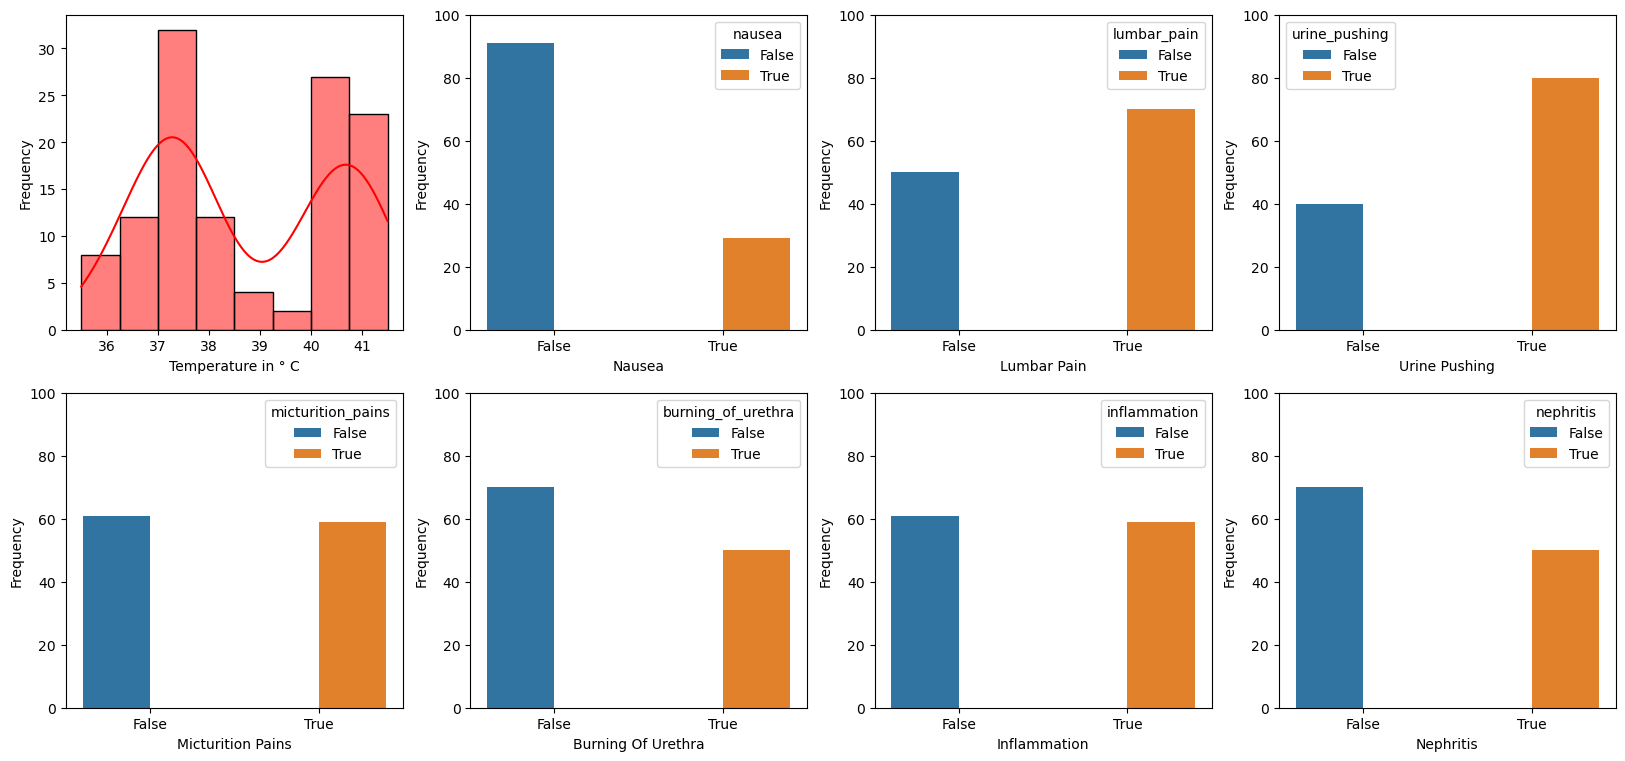

In [7]:
rows = 2
columns = 4
fig,ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,9))
[""]
index = 0 

for row in range(rows):
    for column in range(columns):
        nice_col_name = inflammation_data.columns.to_list()[index]
        nice_col_name = " ".join(word[0].upper() + word[1:] for word in nice_col_name.split("_"))
        
        
        if inflammation_data.columns[index] == 'temperature':
            s = sns.histplot(inflammation_data, ax=ax[row,column], x=inflammation_data.columns[column], kde=True, color='r')
            s.set(xlabel = 'Temperature in ° C', ylabel = "Frequency")
            
        else:
            b = sns.countplot(inflammation_data, x=inflammation_data.columns[index], ax=ax[row,column], hue=inflammation_data.columns[index])
            b.set(xlabel = nice_col_name, ylabel = 'Frequency')
            b.set_ylim(0,100)
            
        index += 1

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

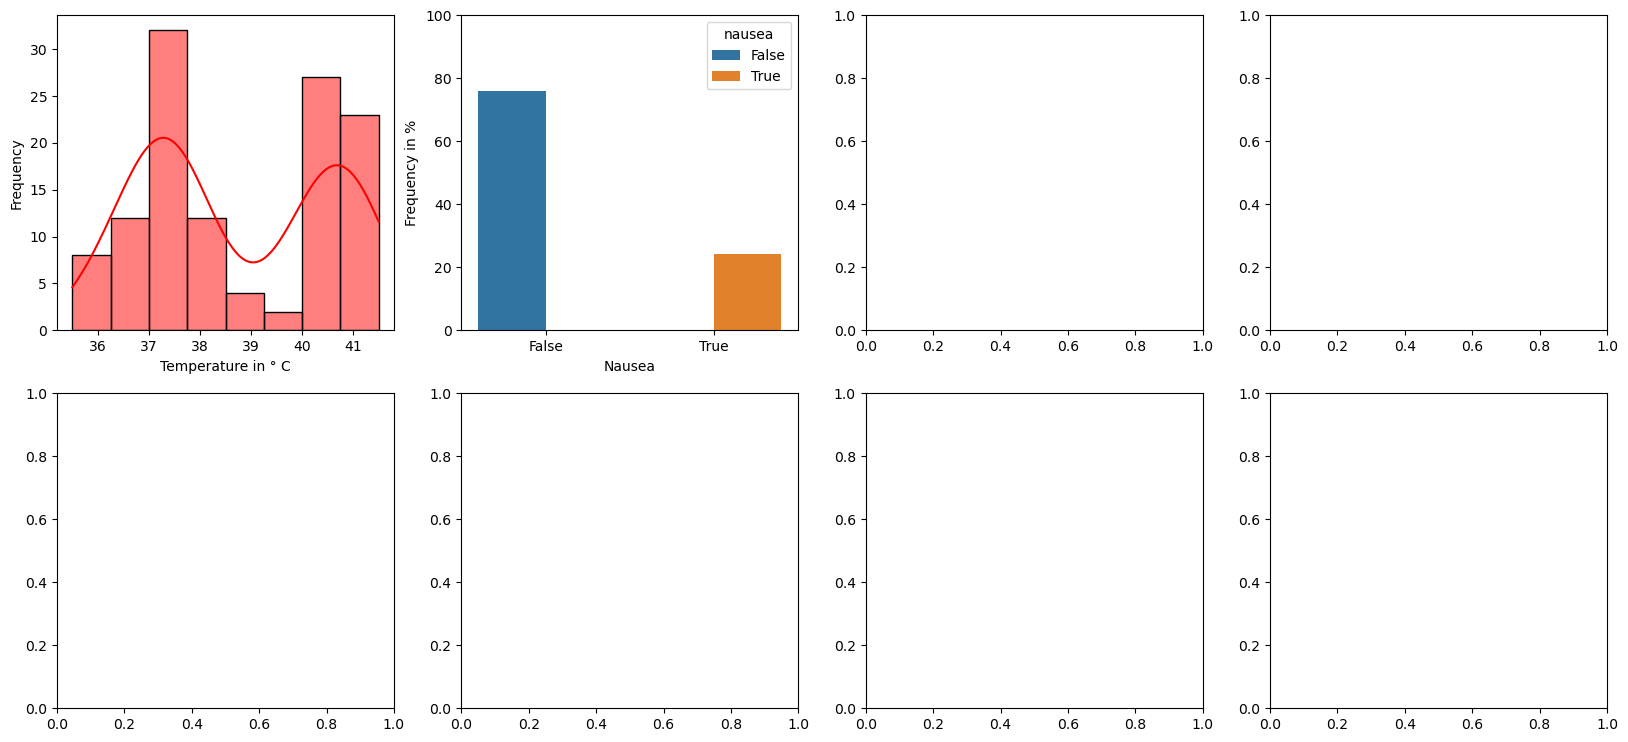

In [8]:
rows = 2
columns = 4
fig,ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,9))
[""]
index = 0 

for row in range(rows):
    for column in range(columns):
        nice_col_name = inflammation_data.columns.to_list()[index]
        nice_col_name = " ".join(word[0].upper() + word[1:] for word in nice_col_name.split("_"))

        current_column = inflammation_data.columns[index]

        if current_column == 'temperature':
            s = sns.histplot(inflammation_data, ax=ax[row,column], x=current_column, kde=True, color='r')
            s.set(xlabel = 'Temperature in ° C', ylabel = "Frequency")
            
        else:
            total_count = len(inflammation_data[current_column])
            percentages = (inflammation_data[current_column].value_counts()/total_count) * 100

            b = sns.barplot(x=percentages.index, y=percentages, ax=ax[row, column], hue=percentages.index)
            b.set(xlabel=nice_col_name, ylabel='Frequency in %')
            b.set_ylim(0,100)
            
        index += 1

## Creating Disease Labels
Based on the appearance of either inflammation or nephritis

In [ ]:
inflammation_data['disease'] = inflammation_data["inflammation"] | inflammation_data["nephritis"]
inflammation_data

# Temperature distribution by diseased or healthy
From the temperature plot it seems as one could approximate two gaussian distributions that relate to the two categories diseased or healthy. To verify this, we plot the temperature grouped by the status of 'disease':

In [ ]:
# Grouping the 'inflammation_data' DataFrame by the 'disease' column, creating separate groups for each unique disease value.
groupby_disease = inflammation_data[['temperature', 'disease']].groupby('disease')

# Select the 'diseased' and 'not diseased' groups
diseased = groupby_disease.get_group(name=True)
healthy = groupby_disease.get_group(name=False)

# Create a figure and a GridSpec layout
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(2, 2, figure=fig)

# Plot the first subplot (diseased) in the first row, first column
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(data=inflammation_data, x='temperature', label='total distribution', color='b', kde=True, ax=ax1)
sns.histplot(data=diseased, x='temperature', label='diseased', color='r', kde=True, ax=ax1)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Temperature in ° C')
ax1.legend()

# Plot the second subplot (healthy) in the first row, second column
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data=inflammation_data, x='temperature', label='total distribution', color='b', kde=True, ax=ax2)
sns.histplot(data=healthy, x='temperature', label='not diseased', color='g', kde=True, ax=ax2)
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Temperature in ° C')
ax2.legend()

# Plot the third subplot (total) in the second row, spanning both columns
ax3 = fig.add_subplot(gs[1, :])
sns.histplot(data=inflammation_data, x='temperature', label='total distribution', color='b', kde=True, ax=ax3)
sns.histplot(data=diseased, x='temperature', label='diseased', color='r', kde=True, ax=ax3)
sns.histplot(data=healthy, x='temperature', label='not diseased', color='g', kde=True, ax=ax3)
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Temperature in ° C')
ax3.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


It seems that, unlike expected from the total distribution, there are no two guassian distributions for diseased and healthy patients. One could assume such a distribution, as an elevated temperature is a typical sign for inflammation. However, looking only at inflammation and nephritis (out of which we generate the disease-column) and temperature, it is visible that there are multiple cases in which relatively low temperatures were measured for patients with either general inflammation or nephritis.

In [ ]:
test = inflammation_data[['inflammation', 'nephritis', 'temperature']].sort_values(by='temperature')
print(test[(test.inflammation==True) | (test.nephritis==True)])

## Splitting the Data
The data is imbalanced towards diseased patients.

In [ ]:
inflammation_data['disease'].value_counts(True)

## Stratifying the Split
Explicitly setting fractions for both classes

In [ ]:
TRAIN_FRACTION = 0.8

train = pd.concat([inflammation_data[inflammation_data['disease'] == True].sample(frac=TRAIN_FRACTION), inflammation_data[inflammation_data['disease'] == False].sample(frac=TRAIN_FRACTION)])
test = inflammation_data.drop(train.index)

## Proving that no train samples are within the test set
By combining the indices of the train and the test-set and checking for duplicates, we can see whether we have rows in both datasets or not:

In [ ]:
indices = train.index.union(test.index)
indices.has_duplicates

## Ensuring that the two dataframes do not share a column
The following merge shows duplicate rows across the two dataframes. If empty, there are no duplicates.

In [ ]:
set(list(test.index)).isdisjoint(list(train.index))

# Shows same values for training and test set, BUT this are not the same patiens, just patients with the same values 

In [ ]:
result = train.merge(right=test, how='inner', indicator=False)
result

If you add a index column and use the same merge function you can see that no rows are left which means that none of the rows or part of both, the train and test set.

In [ ]:
train_1 = train.copy()
test_1 = test.copy()

test_1['original_index'] = range(1, len(test_1) + 1)
train_1['original_index'] = range(1, len(train_1) + 1)

result_1 = train_1.merge(right=test_1, how='inner', indicator=False)
result_1

# Working with the Naive Bayes Classifier
## Creating an instance of NaiveBayes

In [ ]:
naive_bayes = NaiveBayes()

## Fitting the training data

In [ ]:
naive_bayes.fit(data=train, target_name='disease')

## Evaluating on the test set
### Dividing into features and labels
Before evaluation we first need to divide the test set into features (X) and labels (y)

In [ ]:
X_test = test.drop(columns='disease')
y_test = test['disease']

## Evaluating

In [ ]:
accuracy, confusion_matrix_all = naive_bayes.evaluate_on_data(data=X_test, test_labels=y_test)

## Plotting the confusion matrix

In [ ]:
sns.heatmap(data=confusion_matrix_all.iloc[:2,:2], annot=True)
plt.show()